## The Herzprung-Russel diagram

version 1.0 1/3/2018 Wing-Fai Thi
        1.1 3/3/2018 added Affinity Propagation clustering method

In this notebook, several clustering methods such as k-means, DBSCAN, AgglomerativeClustering, Gaussian Mixture and outlier detection methods are used to analyse one of the fundamental plot in astronomy, the so-called Hertzprung-Russel diagram (HR diagram)

### The astronomical background
- See the astrostatistic website 
- https://en.wikipedia.org/wiki/Hyades_(star_cluster)
- The figure shows a HR-diagram constructed with stars in the Hipparcos catalogues (from Wikipedia).
http://astrostatistics.psu.edu/datasets/HIP_star.html

<img src="HRDiagram.png" />
credit: Wikipedia

### Dataset from
- http://astrostatistics.psu.edu/datasets/HIP_star.html
- It contains a subset of 2719 stars from the Hipparcos catalogue.
- They were selected to have paralax to lie between 20 and 25 mas (i.e. Hipparcos stars with distances 40-50 pc).

### This dataset has the following columns:
- HIP = Hipparcos star number
- Vmag = Visual band magnitude.  This is an inverted logarithmic measure of brightness 
- RA = Right Ascension (degrees), positional coordinate in the sky equivalent to longitude on the Earth
- DE = Declination (degrees), positional coordinate in the sky equivalent to latitude on the Earth
- Plx = Parallactic angle (mas = milliarcsseconds).  1000/Plx gives the distance in parsecs (pc)
- pmRA = Proper motion in RA (mas/yr).  RA component of the motion of the star across the sky 
- pmDE = Proper motion in DE (mas/yr). DE component of the motion of the star across the sky
- e_Plx = Measurement error in Plx (mas)
- B-V = Color of star (mag)

### References:
- Modern Statistical Methods for Astronomy E. Feigelson & J. Babu, Cambdridge Univeristy Press
- scikit-learn manual
- any introductionary textbook on astronomy
- Statistics, Data Mining, and Maching Learning in astronomy Ivezic et al. Princeton Series in Modern Observational Astronomy

### Aim of the notebook

We will perform the same assigments than on the original website:
- Find Hyades cluster members, and possibly Hyades supercluster members, by multivariate clustering.
- Validate the sample, and reproduce other results of Perryman et al. (1998) Astron. Astrophys. 331, 81–120. The Hyades: distance, structure, dynamics, and age
- Construct the HR diagram, and discriminate the main sequence and red giant branch in the full database and Hyades subset.  Can anything be learned about the "red clump" subgiants?
- Isolate the Hyades main sequence and fit with nonparametric local regressions and with parametric regressions.
- Use the heteroscedastic measurement error values e_Plx to weight the points in all of the above operations. Can any unusual outliers be found? (white dwarfs, halo stars, runaway stars, ...)

### Methods

We will use a couple of outlier detection algorithms:
- Local Outlier Factor, Robust Covariance, Isolation Tree, One class SVM.
- as well as the clustering methods k-Means, Gaussain Mixtures, and DBSCAN

In [1]:
print(__doc__)
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns; sns.set()
from sklearn.preprocessing import StandardScaler
# DBSCAN algorithm
from sklearn.cluster import DBSCAN
# K-mean algorithm
from sklearn.cluster import KMeans
# Local Outlier Factor
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn import svm
import itertools
from sklearn import mixture

Automatically created module for IPython interactive environment


In [2]:
fpath = "HIP_star.dat"
df=pd.read_table(fpath,delim_whitespace=True).dropna()
df.head()

,HIP,Vmag,RA,DE,Plx,pmRA,pmDE,e_Plx,B-V
0,2,9.27,0.003797,-19.498837,21.90,181.21,-0.93,3.10,0.999
1,38,8.65,0.111047,-79.061831,23.84,162.30,-62.40,0.78,0.778
2,47,10.78,0.135192,-56.835248,24.45,-44.21,-145.90,1.97,1.150
3,54,10.57,0.151656,17.968956,20.97,367.14,-19.49,1.71,1.030
4,74,9.93,0.221873,35.752722,24.22,157.73,-40.31,1.36,1.068


#### Part 1

Cluster finding in the HR diagram containing all the objects in the dataset.

In [3]:
print "Numfer of objects:",df.shape[0]

Numfer of objects: 2678


In [4]:
# One object mentionned in the Perryman et al. paper is not in the 
# current dataset.
# The paper argue that HIP 21670 may be a unregcognized binary
df[df['HIP'] == 21670]

,HIP,Vmag,RA,DE,Plx,pmRA,pmDE,e_Plx,B-V


In [5]:
df[df['HIP'] == 20614]

,HIP,Vmag,RA,DE,Plx,pmRA,pmDE,e_Plx,B-V
599,20614,5.97,66.237749,19.042092,20.4,110.73,-32.5,0.74,0.378


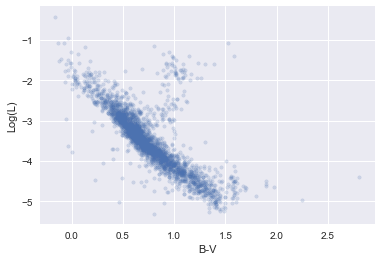

In [6]:
BV = df['B-V']
LogL = (15.-df['Vmag']-5.*np.log(df['Plx']))/2.5
plt.scatter(BV,LogL,alpha=0.2,marker=".")
plt.xlabel('B-V')
plt.ylabel('Log(L)')
plt.show()

First we construct a Herzprung-Russel (HR) diagram for all the object by plotting logL as a function of B-V, where the log-luminosity in units of solar luminosity is given by logL=(15 - Vmag - 5logPlx)/2.5. The formula correct the Vmag for the distance given by Plx. The HR diagram is contaminated by stars that do not belong to the Hyades cluster.
Let's try to find the Red giant branches by using the DBSCAN.

In [7]:
X = np.vstack((BV,LogL))
X =X.T
Xs = StandardScaler().fit_transform(X)
db = DBSCAN(eps=0.2,min_samples=10).fit(Xs)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
cluster_labels = db.labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
print('Estimated number of clusters: %d' % n_clusters_)

Estimated number of clusters: 5


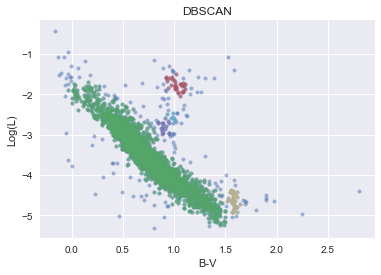

In [8]:
def plot_HR_clustering(title):
    plt.scatter(BV,LogL,alpha=0.5,marker=".")
    plt.xlabel('B-V')
    plt.ylabel('Log(L)')
    plt.title(title)
    for i in range(n_clusters_):
        plt.scatter(BV[cluster_labels == i],LogL[cluster_labels == i],
                        alpha=0.5,marker=".")
plot_HR_clustering('DBSCAN')

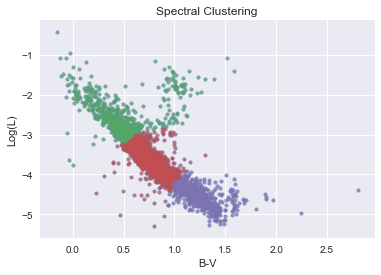

In [9]:
from sklearn.cluster import SpectralClustering
n_clusters_ = 3
spectral = SpectralClustering(
    n_clusters=n_clusters_, eigen_solver='arpack',
    affinity="nearest_neighbors")
spectral.fit(Xs)
cluster_labels = spectral.labels_
plot_HR_clustering("Spectral Clustering")

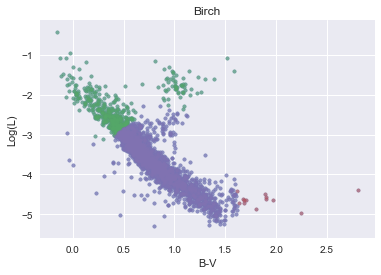

In [10]:
# Birch
from sklearn.cluster import Birch
n_clusters_ = 3
birch = Birch(n_clusters=n_clusters_)
birch.fit(Xs)
cluster_labels = birch.labels_
plot_HR_clustering("Birch")

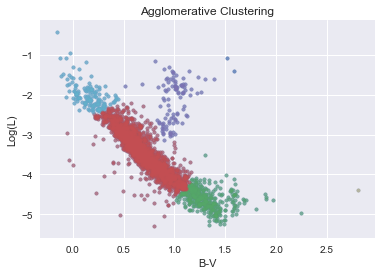

In [11]:
from sklearn.cluster import AgglomerativeClustering
n_clusters_ = 6
ACmodel = AgglomerativeClustering(n_clusters=n_clusters_,
                                  affinity='euclidean',linkage='average')
ACmodel.fit(Xs)
cluster_labels = ACmodel.labels_
plot_HR_clustering("Agglomerative Clustering")

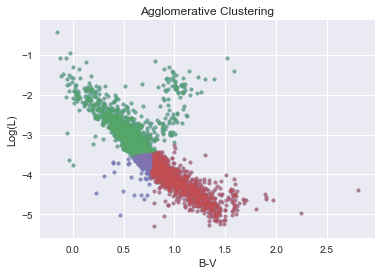

In [12]:
n_clusters_ = 3
ACmodel = AgglomerativeClustering(n_clusters=n_clusters_,
                                  affinity='cosine',linkage='complete')
ACmodel.fit(Xs)
cluster_labels = ACmodel.labels_
plot_HR_clustering("Agglomerative Clustering")

number of estimated clusters : 4


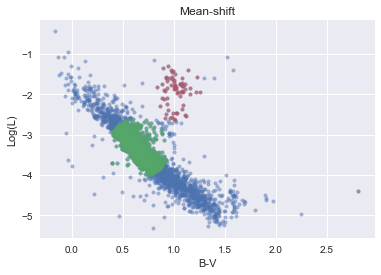

In [13]:
# mean-shift clustering algorithm
from sklearn.cluster import MeanShift, estimate_bandwidth
bandwidth = estimate_bandwidth(Xs, quantile=0.3, n_samples=100)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True,cluster_all=False)
ms.fit(Xs)
cluster_labels = ms.labels_
plot_HR_clustering("Mean-shift")
cluster_centers = ms.cluster_centers_
labels_unique = np.unique(cluster_labels)
n_clusters_ = len(labels_unique)
print("number of estimated clusters : %d" % n_clusters_)

We try a Gaussian Mixture model with the Bayesain Information Criterion (BIC) to choose the best number of groups.

In [14]:
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
lowest_bic = np.infty
bic = []
n_components_range = range(1, 9)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
    #Fit a Gaussian mixture with EM
        gmm = GaussianMixture(n_components=n_components,
        covariance_type=cv_type)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm
            nbest = n_components

bic = np.array(bic)
color_iter = itertools.cycle(['blue','silver','darkgoldenrod','darkgreen',
                              'darkmagenta','red','darkorange','gold',
                              'darkorchid','aqua'])
clf = best_gmm # save the model with the lowest BIC
bars = []
print "Best model number of components:",nbest

Best model number of components: 7


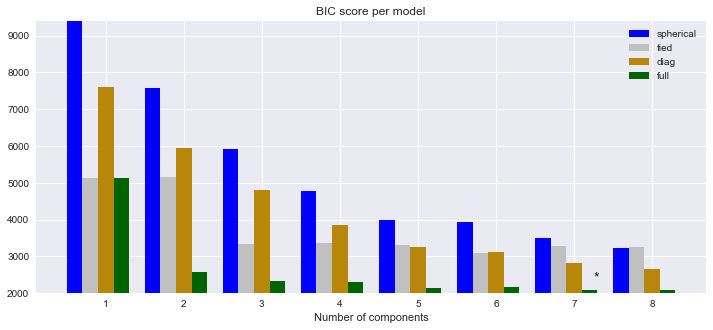

In [15]:
# Plot the BIC scores
plt.subplots(figsize=(12, 5))
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
    (i + 1) * len(n_components_range)],
    width=.2, color=color))

plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
.2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
plt.xlabel('Number of components')
plt.legend([b[0] for b in bars], cv_types)
plt.show()

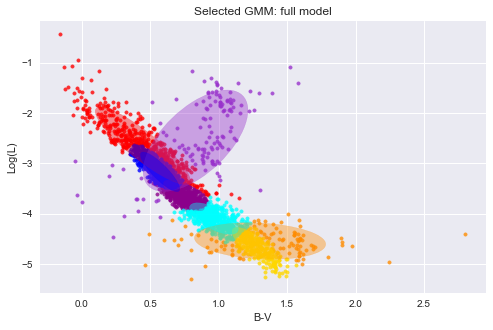

In [16]:
# Plot the best solution
splot= plt.subplots(figsize=(8, 5))
splot = plt.subplot(111)
Y_ = clf.predict(X)
for i, (mean, cov, color) in enumerate(zip(clf.means_, 
                                        clf.covariances_,color_iter)):
    v, w = np.linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], alpha=0.8, 
                color=color,marker=".")
    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180. * angle / np.pi # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 
                              180. + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(.4)
    splot.add_artist(ell)
    
plt.xlabel('B-V')
plt.ylabel('Log(L)')
plt.title('Selected GMM: full model')
plt.show()

Obviously, the Gaussian mixture method is not efficient when the groups are not blobs! The shape of the main-sequence stars cannot be captured by a single gaussian, instead 4 gaussians are required.

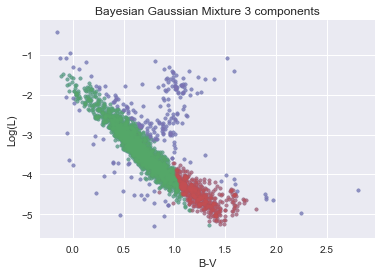

In [17]:
n_clusters_ = 3
gmmBayes = BayesianGaussianMixture(n_components=n_clusters_)
gmmBayes.fit(Xs)
cluster_labels = gmmBayes.predict(Xs)
plot_HR_clustering("Bayesian Gaussian Mixture 3 components")

In [18]:
# Minimum Spanning Tree
from scipy.interpolate import interp1d
from scipy.sparse.csgraph import minimum_spanning_tree
from sklearn.neighbors import kneighbors_graph
#------------------------------------------------------------
# generate a sparse graph using the k nearest neighbors of each point
G = kneighbors_graph(Xs, n_neighbors=10, mode='distance')
#------------------------------------------------------------
# Compute the minimum spanning tree of this graph
T = minimum_spanning_tree(G, overwrite=True)
#------------------------------------------------------------
# Get the x, y coordinates of the beginning and end of each line segment
T = T.tocoo()
dist = T.data
p1 = T.row
p2 = T.col
A = Xs[p1].T
B = Xs[p2].T
x_coords = np.vstack([A[0], B[0]])
y_coords = np.vstack([A[1], B[1]])

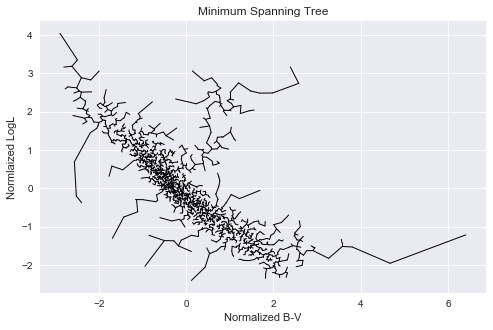

In [19]:
splot= plt.subplots(figsize=(8, 5))
splot = plt.subplot(111)
plt.plot(x_coords, y_coords, c='k', lw=1)
plt.ylabel('Normlaized LogL')
plt.xlabel('Normalized B-V')
plt.title('Minimum Spanning Tree')
plt.show()


A smooth density estimator convolve the discrete data with a kernel function. The scientist makes two choices:
- the kernel's functional form
- the kernel smoothing parameter of bandwidth. The choice of the bandwith h is more important than that of the kernel
    - proximity of the kernel density estimator to the underlaying pdf
    - minimize the mean integrated square error (MISE), the sum of:
        - Bias tern measures the averaged squared deviation of the estimator from the pdf decreases rapidly as the bandwith narrowed
        - Variance decreaes as the bandwith is widenened
        - the optimal bandwidth is chosen at the value that minimized the MISE
        
Choice of the bandwidth by:
- cross-validation: leave-on-out cross-validation


In [20]:
from skimage.morphology import skeletonize
from skimage.util import invert
from sklearn.neighbors import KDTree, KernelDensity
from astroML.density_estimation import KNeighborsDensity
# Kernel Density Estimation
def kde2D(x,y,bandwidth=0.1,xbins=100j,ybins=100j,**kwargs):
    # create grid of sample locatios (default: 100x100)
    xx,yy = np.mgrid[x.min():x.max():xbins,
                    y.min():y.max():ybins]
    xy_sample = np.vstack([yy.ravel(),xx.ravel()]).T
    xy_train = np.vstack([y,x]).T
    kde_skl = KernelDensity(bandwidth=bandwidth,**kwargs)
    kde_skl.fit(xy_train)
    # score_Samples() returns the log_likelihood of the samples
    z = np.exp(kde_skl.score_samples(xy_sample))
    return xx,yy,np.reshape(z,xx.shape)

# k-neighbors Density Estimation
# practical but not statisticaly valid
# also prone to local noise
# example of usage in astronomy J Wang 2009
def knd2D(x,y,method='bayesian',nneighbours=5,xbins=100j,ybins=100j):
    # create grid of sample locatios (default: 100x100)
    xx,yy = np.mgrid[x.min():x.max():xbins,
                    y.min():y.max():ybins]
    xy_sample = np.vstack([yy.ravel(),xx.ravel()]).T
    xy_train = np.vstack([y,x]).T
    knn = KNeighborsDensity(method,nneighbours)
    z = knn.fit(xy_train).eval(xy_sample)
    return xx,yy,np.reshape(z,xx.shape)

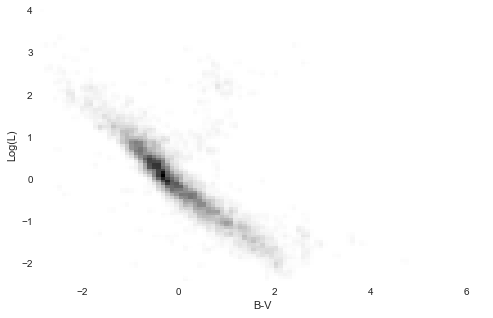

In [21]:
# no CV search of the optimal bandwith is performed here
xx,yy,zz = kde2D(Xs[:,0],Xs[:,1],bandwidth=0.05,xbins=100j,ybins=100j)
splot= plt.subplots(figsize=(8, 5))
splot = plt.subplot(111)
plt.xlabel('B-V')
plt.ylabel('Log(L)')
plt.pcolormesh(xx,yy,zz,cmap=plt.cm.binary)
plt.show()

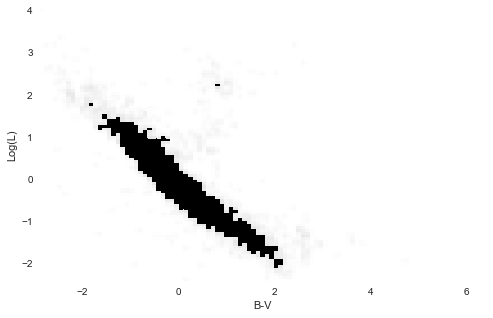

In [22]:
zz[zz > 0.1]=1.
splot= plt.subplots(figsize=(8, 5))
splot = plt.subplot(111)
plt.xlabel('B-V')
plt.ylabel('Log(L)')
plt.pcolormesh(xx,yy,zz,cmap=plt.cm.binary)
plt.show()

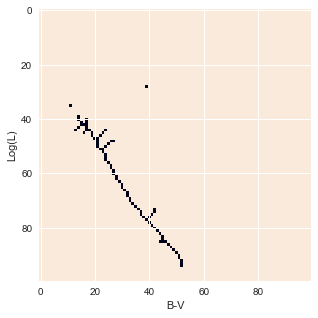

In [23]:
skeleton=invert(np.rot90(skeletonize(zz)))
plt.subplots(figsize=(8, 5))
plt.subplot(111)
plt.xlabel('B-V')
plt.ylabel('Log(L)')
plt.imshow(skeleton)
plt.show()

#### Part 2

We will try to find the Hyades members among all the stars in the dataset.

I choose arbitrary a box of 15 x 15 arcsec around the position RA=67 deg, Dec = 16 deg.

In [24]:
delta_RA = 15.
delta_DE = 15.
RA_center = 67.
DE_center = 16.
df_area = df[(abs(df['RA']-RA_center) < delta_RA) 
             & (abs(df['DE']-DE_center) < delta_DE)]
df_area.shape

(160, 9)

We end-up with 160 candidates.

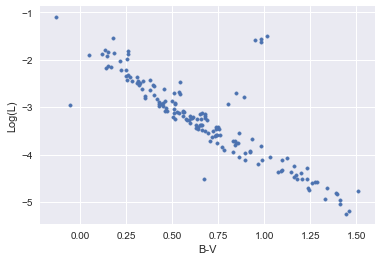

In [25]:
LogL = (15.-df_area['Vmag']-5.*np.log(df_area['Plx']))/2.5
plt.scatter(df_area['B-V'],LogL,alpha=1.0,marker=".")
plt.xlabel('B-V')
plt.ylabel('Log(L)')
plt.show()

In [26]:
features = ['pmRA','pmDE']
# df_Hip is a DataFrame containing the proper motions
df_Hip = df_area[features] 
X_Hip = np.array(df_Hip)
df_Hip.head()

,pmRA,pmDE
459,341.88,-321.48
462,322.67,14.80
464,155.02,-63.38
468,-112.36,-196.42
471,160.99,-40.55


The sky positions of the Hyades members are centered around RA=67 degrees & DE=+16 degrees, but they also share converging proper motions with vector components pmRA and pmDE. We select RA, DE, pmRA, and pmDe as our features.

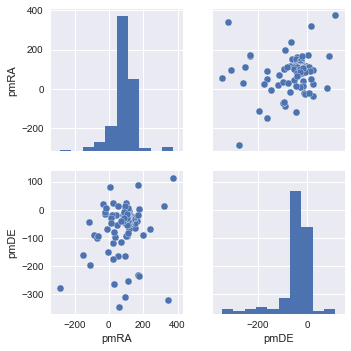

In [27]:
# Basic correlogram using seaborn
sns.pairplot(df_Hip)

In [28]:
k_means = KMeans(n_clusters=1, random_state=19080)
k_means.fit(X_Hip)
print "Cluster centers:"
dfk=pd.DataFrame(k_means.cluster_centers_,columns=features)
dfk

Cluster centers:


,pmRA,pmDE
0,93.029813,-46.521062


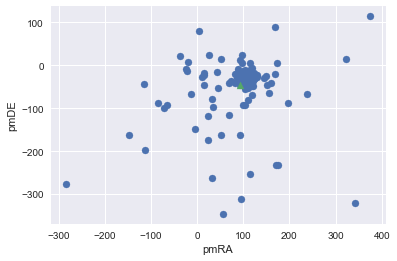

[ 0.61880571  0.38119429]


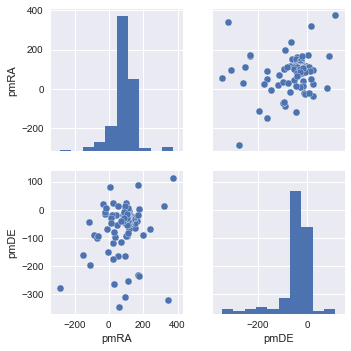

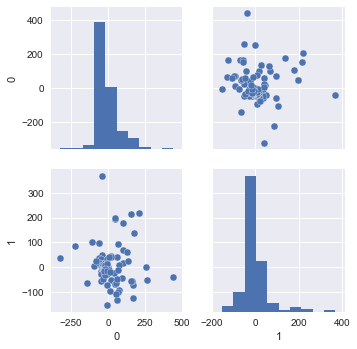

In [29]:
plt.scatter(df_Hip['pmRA'],df_Hip['pmDE'])
plt.xlabel('pmRA')
plt.ylabel('pmDE')
plt.scatter(k_means.cluster_centers_[:,0],
            k_means.cluster_centers_[:,1],marker="^")
plt.show()

# PCA
from sklearn.decomposition import PCA
#help("sklearn.decomposition.PCA")
pca = PCA(n_components=2)
Xpca = pca.fit_transform(X_Hip)
df_pca_Hip = pd.DataFrame(Xpca)
Xinv = pca.inverse_transform(Xpca)
print pca.explained_variance_ratio_

sns.pairplot(df_Hip)
sns.pairplot(df_pca_Hip)
plt.show()

We checked that the features are not correlated with each other. The PCA
transform does not permit to find clear outliers.

The velocity ellipsoid ofr a given population of stars. Other population with different kinematics may contaminate the sample. The appropriate method is to use the median instead of the mean and interquatile range to estimate variances.

We will use different outlier detection methods:
- a robust estimator of covariance,which is assuming that the data are Gaussian distributed
- the One-Class SVM and its ability to capture the shape of the data set, hence performing better when the data is strongly non-Gaussian, i.e. with two well-separated clusters
- the Local Outlier Factor to measure the local deviation of a given data point with respect to its neighbors by comparing their local density
- the Isolation Forest algorithm, which is based on random forests and hence more adapted to large-dimensional settings
- the Minimum Covariance Determinant estimator (MCD)
- we will gather all the relevant outlier estimate and perform a 'vote'

selected/total= 112 / 160


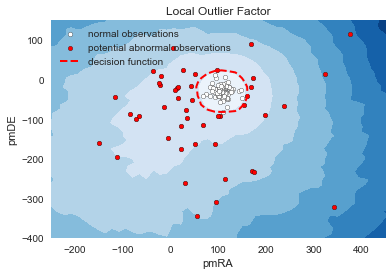

In [30]:
label_list = []
# fit the model
outliers_fraction = 0.3
clf = LocalOutlierFactor(n_neighbors=50,contamination=outliers_fraction)
labels = clf.fit_predict(X_Hip)
label_list.append(labels)
scores_pred = clf.negative_outlier_factor_
woutliers = np.where(labels == -1)
wHya       = np.array(np.where(labels == 1))
print "selected/total=",wHya.size,'/',X_Hip.shape[0]

xx, yy = np.meshgrid(np.linspace(-250, 450, 50), 
                     np.linspace(-400, 150, 50))
ZZ = clf._decision_function(np.c_[xx.ravel(), yy.ravel()])
ZZ = ZZ.reshape(xx.shape)
title = "Local Outlier Factor"

def plot_outliers(X):
    threshold = stats.scoreatpercentile(scores_pred, 
                                        100 * outliers_fraction)
    # plot the level sets of the decision function
    plt.title(title)
    plt.contourf(xx, yy, ZZ, cmap=plt.cm.Blues_r)
    a = plt.scatter(X[:, 0], X[:, 1], c='white',
                edgecolor='k', s=20)
    b = plt.scatter(X[woutliers, 0], X[woutliers, 1], c='red',
                edgecolor='k', s=20)
    c = plt.contour(xx, yy, ZZ, levels=[threshold], 
                    linewidths=2, colors='red')
    plt.axis('tight')
    plt.xlim((-250, 450))
    plt.ylim((-400, 150))
    plt.legend([a, b, c.collections[0]],
           ["normal observations",
            "potential abnormal observations","decision function"],
           loc="upper left")
    plt.xlabel(features[0])
    plt.ylabel(features[1])
    plt.show()

plot_outliers(X_Hip)

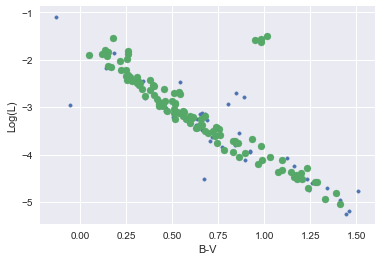

In [31]:
def plot_HR_Hyades():
    plt.scatter(BV,LogL,alpha=1,marker=".")
    plt.scatter(BV[labels == 1],LogL[labels == 1],
                alpha=1,marker="o")
    plt.xlabel('B-V')
    plt.ylabel('Log(L)')
    plt.show()

# select B-V color and LogL within the area for the rest of 
# the notebook   
LogL = np.array((15.-df_area['Vmag']-5.*np.log(df_area['Plx']))/2.5)
BV   = np.array(df_area['B-V'])
plot_HR_Hyades()

In [32]:
# Ref. 
# Statistics Data Mining and Machine Learning in Astronomy
# Shevlyakov G. and P Smirnov 2011
# Robust estimation of the correlation coefficient
# An attempt of survey Austrian Journal of Statistics 40, 147-156
from astroML.stats import fit_bivariate_normal
#help("astroML.stats.fit_bivariate_normal")
# mu : tuple
#        (x, y) location of the best-fit bivariate normal
#    sigma_1, sigma_2 : float
#        The best-fit gaussian widths in the uncorrelated frame
#    alpha : float
#        The rotation angle in radians of the uncorrelated frame
mean,sigma,sigma2,alpha=fit_bivariate_normal(X_Hip[:,0],X_Hip[:,1]
                                             ,robust=False)
print 'Non robust:',mean, sigma, sigma2, alpha 
mean,sigma,sigma2,alpha=fit_bivariate_normal(X_Hip[:,0],X_Hip[:,1]
                                             ,robust=True)
print 'Robust:',mean, sigma, sigma2, alpha

Non robust: [93.02981250000002, -46.521062500000006] 77.1489643914 60.5516713821 0.634757483059
Robust: [105.23, -29.795000000000002] 19.6301116814 15.6438600495 1.20953718516


#### Minimum Covariance Determinant (MCD) robust estimator

Minimum covariance determinant proposed by P.J.Rousseuw
(see Mia Hubert and Michiel Debruyne)

https://wis.kuleuven.be/stat/robust/papers/2010/wire-mcd.pdf

The robust covariance use the mean (q50) instead of the mean and use sG= 0.7413(q75-q25) instead of standard deviation. It selected 112 out of 160 candidates.

selected/total= 112 / 160


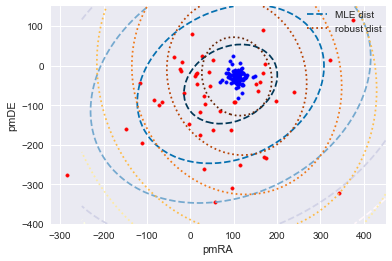

In [33]:
from sklearn.covariance import EmpiricalCovariance, MinCovDet
#help("sklearn.covariance.MinCovDet")
# fit a Minimum Covariance Determinant (MCD) robust estimator to data
# The Minimum Covariance Determinant estimator (MCD) has been introduced 
# P.J.Rousseuw
# Least median of squares regression. 
# Journal of American Statistical Ass., 79:871, 1984.
robust_cov = MinCovDet(random_state=2001).fit(X_Hip)
# compare estimators learnt from the full data set with true parameters
emp_cov = EmpiricalCovariance().fit(X_Hip)
# create a mesh grid xx,yy
xx, yy = np.meshgrid(np.linspace(-250, 450, 50), 
                     np.linspace(-400, 150, 50))
zz = np.c_[xx.ravel(), yy.ravel()]
mahal_emp_cov = emp_cov.mahalanobis(zz)
mahal_emp_cov = mahal_emp_cov.reshape(xx.shape)
mahal_robust_cov = robust_cov.mahalanobis(zz)
mahal_robust_cov = mahal_robust_cov.reshape(xx.shape)
robust_pred = robust_cov.mahalanobis(X_Hip)
dist = 20. # selection criterion
wHya = np.array(np.where(robust_pred <= dist))
print "selected/total=",wHya.size,'/',X_Hip.shape[0]

labels = np.empty(X_Hip.shape[0])
members = (robust_pred <= dist)
outliers = (robust_pred > dist)
labels[members]  = 1.
labels[outliers] = -1.
label_list.append(labels)
# Display
fig = plt.figure()
plt.scatter(X_Hip[members, 0], 
            X_Hip[members, 1],marker=".",color='blue')
plt.scatter(X_Hip[outliers, 0], 
            X_Hip[outliers, 1],marker=".",color='red')
emp_cov_contour = plt.contour(xx, yy, np.sqrt(mahal_emp_cov),
                                  cmap=plt.cm.PuBu_r,
                                  linestyles='dashed')
robust_contour = plt.contour(xx, yy, np.sqrt(mahal_robust_cov),
                            cmap=plt.cm.YlOrBr_r, linestyles='dotted')
plt.legend([emp_cov_contour.collections[1], 
            robust_contour.collections[1]],
               ['MLE dist', 'robust dist'],
               loc="upper right", borderaxespad=0)
plt.xlabel(features[0])
plt.ylabel(features[1])
plt.show()

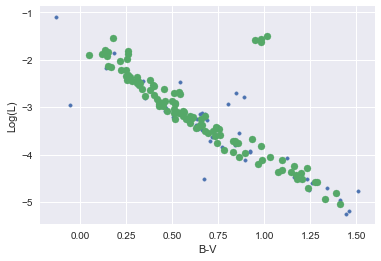

In [34]:
plot_HR_Hyades()

selected/total= 112 / 160
Maximum squared Mahalanobis distance: 19.091666177


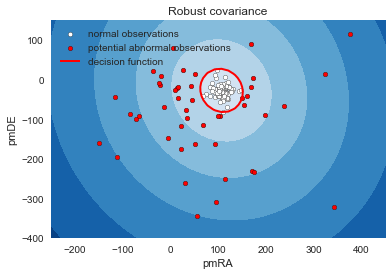

In [35]:
# Robust covariance with the EllipticEnvelope
outliers_fraction = 0.3
clf = EllipticEnvelope(contamination=outliers_fraction)
clf.fit(X_Hip)
scores_pred = clf.decision_function(X_Hip)
labels = clf.predict(X_Hip)
label_list.append(labels)
EllipticEnv_Mah=clf.mahalanobis(X_Hip)
woutliers = np.where(labels == -1)
wHya     = np.array(np.where(labels == 1))
print "selected/total=",wHya.size,'/',X_Hip.shape[0]
print "Maximum squared Mahalanobis distance:",EllipticEnv_Mah[wHya].max()
ZZ = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
ZZ = ZZ.reshape(xx.shape)
title = "Robust covariance"
plot_outliers(X_Hip)

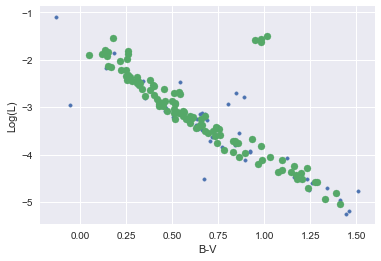

In [36]:
plot_HR_Hyades()

The red clump (high B-V) subgiants (high Log(L)) are plotted in red. The main-sequence stars are in green. A few objects have been excluded by the algorithms and they are shown in light blue.

Third method: the isolation tree

In [37]:
outliers_fraction = 0.3
rng = 123153
n_samples = 100
clf=IsolationForest(max_samples=n_samples,contamination=outliers_fraction,
random_state=rng)
clf.fit(X_Hip)
scores_pred = clf.decision_function(X_Hip)
labels = clf.predict(X_Hip)
label_list.append(labels)
woutliers = np.where(labels == -1)
wHya     = np.array(np.where(labels == 1))
print "selected/total=",wHya.size,'/',X_Hip.shape[0]

ZZ = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
ZZ = ZZ.reshape(xx.shape)
title = "Isolation Tree"

selected/total= 112 / 160


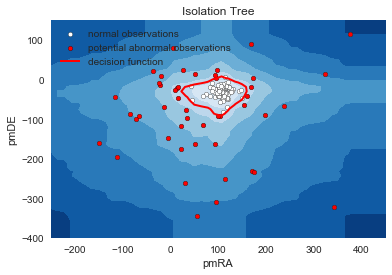

In [38]:
plot_outliers(X_Hip)

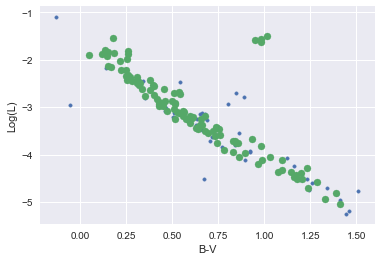

In [39]:
plot_HR_Hyades()

In [40]:
from sklearn.svm import OneClassSVM
outliers_fraction = 0.3
kernel = "rbf" 
clf=OneClassSVM(nu=0.95 * outliers_fraction + 0.05,
                kernel=kernel, gamma=0.1)
clf.fit(X_Hip)
scores_pred = clf.decision_function(X_Hip)
labels = clf.predict(X_Hip)
label_list.append(labels)
woutliers = np.where(labels == -1)
wHya     = np.array(np.where(labels == 1))

print "selected/total=",wHya.size,'/',X_Hip.shape[0]

selected/total= 85 / 160


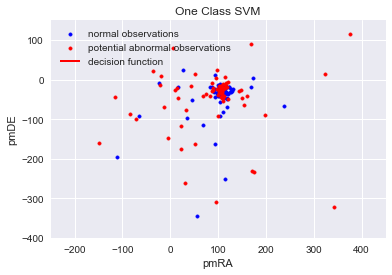

In [41]:
xx, yy = np.meshgrid(np.linspace(-250, 450, 50), 
                     np.linspace(-400, 150, 50))
ZZ = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
ZZ = ZZ.reshape(xx.shape)
threshold = 0.

fig = plt.figure()
a = plt.scatter(X_Hip[wHya, 0], 
            X_Hip[wHya, 1],marker=".",color='blue')
b = plt.scatter(X_Hip[woutliers, 0], 
            X_Hip[woutliers, 1],marker=".",color='red')
c = plt.contour(xx, yy, ZZ, levels=[threshold], 
                    linewidths=2, colors='red')
plt.axis('tight')
plt.xlim((-250, 450))
plt.ylim((-400, 150))
plt.legend([a, b, c.collections[0]],
           ["normal observations",
            "potential abnormal observations","decision function"],
           loc="upper left")
plt.xlabel(features[0])
plt.ylabel(features[1])
plt.title("One Class SVM")
plt.show()

SVM One class fails in this case. 
Notice that the member selection depends on the algortihms hyper-parameters such as a guest of the outlier fraction, here set to 30% (0.3).

The different methods here are quite consistent with each other in the selection of the Hyades members.

The issue is that the amount of contamination has to been known in advance.

#### DBSCAN

Use DBSCAN as an outlier detection algorithm

Estimated number of clusters: 1
selected/total= 111 / 160


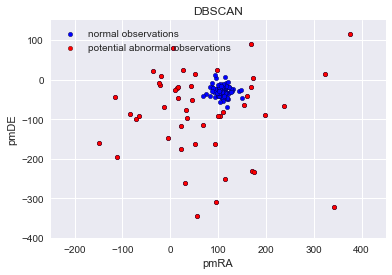

In [42]:
# DBSCAN 
# key parameters are eps and min_samples
# eps is the maximum distance between two samples for them to be 
# considered as in the same neighborhood.
# min_samples to exclude isolated objects
# eps is basically the Maximum squared Mahalanobis distance
# help("sklearn.cluster.DBSCAN")
db = DBSCAN(eps=19.5,min_samples=5).fit(X_Hip)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
# Number of clusters in labels, ignoring the outliers if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
# one 'plays' with the parameters to ensure 1 cluster is found
print('Estimated number of clusters: %d' % n_clusters_)
woutliers = np.where(labels == -1)
wHya     = np.array(np.where(labels == 0))
labels[db.labels_ == 0] = 1 # change the label for members from 0 to 1
label_list.append(labels)
outliers_fraction = wHya.size*1./X_Hip.shape[0]
print "selected/total=",wHya.size,'/',X_Hip.shape[0]
# -----
plt.title("DBSCAN")
a = plt.scatter(X_Hip[:, 0], X_Hip[:, 1], c='blue',
                edgecolor='k', s=20)
b = plt.scatter(X_Hip[woutliers, 0], X_Hip[woutliers, 1], c='red',
                edgecolor='k', s=20)
plt.axis('tight')
plt.xlim((-250, 450))
plt.ylim((-400, 150))
plt.legend([a, b],
           ["normal observations",
            "potential abnormal observations"],
           loc="upper left")
plt.xlabel(features[0])
plt.ylabel(features[1])
plt.show()

In [43]:
from sklearn.cluster import AffinityPropagation
from sklearn.metrics import silhouette_score
# Compute Affinity Propagation
# damping=0.99,preference=-30000
af = AffinityPropagation(damping=0.95,preference=-30000).fit(X_Hip)
cluster_centers_indices = af.cluster_centers_indices_
af_labels = af.labels_
n_clusters_ = len(cluster_centers_indices)
print('Estimated number of clusters: %d' % n_clusters_)
woutliers = np.where(af_labels == 1)
wHya     = np.array(np.where(af_labels == 0))
labels[af_labels == 0] = 1 # change the label for members from 0 to 1
labels[af_labels == 1] = -1
label_list.append(labels)
outliers_fraction = wHya.size*1./X_Hip.shape[0]
print "selected/total=",wHya.size,'/',X_Hip.shape[0]

print("Silhouette Coefficient: %0.3f"
      % silhouette_score(X_Hip, af_labels, metric='sqeuclidean'))

Estimated number of clusters: 2
selected/total= 28 / 160
Silhouette Coefficient: 0.697


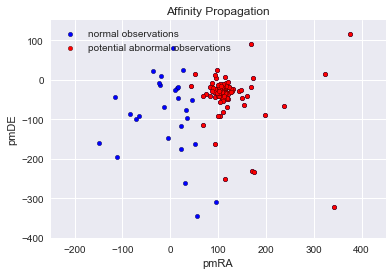

In [86]:
# -----
def plot_outliers2(title):
    plt.figure()
    a = plt.scatter(X_Hip[:, 0], X_Hip[:, 1], c='blue',
                edgecolor='k', s=20)
    b = plt.scatter(X_Hip[woutliers, 0], X_Hip[woutliers, 1], c='red',
                edgecolor='k', s=20)
    plt.axis('tight')
    plt.xlim((-250, 450))
    plt.ylim((-400, 150))
    plt.legend([a, b],
           ["normal observations",
            "potential abnormal observations"],
           loc="upper left")
    plt.xlabel(features[0])
    plt.ylabel(features[1])
    plt.title(title)
    plt.show()

plot_outliers2("Affinity Propagation")

number of estimated clusters : 2
Silhouette Coefficient: 0.823


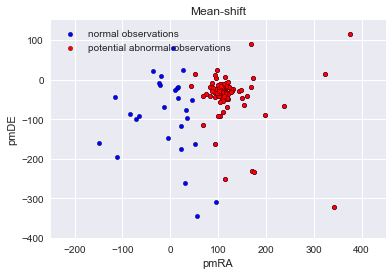

In [87]:
# Compute clustering with MeanShift
# The following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(X_Hip, quantile=0.9, 
                               n_samples=X_Hip.shape[0])
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True,
               cluster_all=True)
ms.fit(X_Hip)
labels = ms.labels_
cluster_centers = ms.cluster_centers_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)
print("number of estimated clusters : %d" % n_clusters_)
print("Silhouette Coefficient: %0.3f"
      % silhouette_score(X_Hip, labels, metric='sqeuclidean'))
labels[labels == 0] = -1 # change the label for non members to -1
plot_outliers2("Mean-shift")


• All algorithms performed well apart from the One-Class SVM and the Affinity Propagation for the current situation

• because the One-Class SVM has the ability to capture the shape of the data set, hence performs better when the data is strongly non-Gaussian, i.e. with two well-separated clusters, which is not the case here.

• using the Isolation Forest algorithm, which is based on random forests and hence more adapted to large- dimensional settings

• using the Local Outlier Factor to measure the local deviation of a given data point with respect to its neighbors by comparing their local density.

• DBSCAN can be used to find outliers if one knows the maximum squared Mahalanobis distance

• the affinity propagation method is not designed to find outliers. It was here a test like using DBSCAN. But DBSCAN may be more suitable for outlier detection because it is allowed to assign no membership to data points.

• one should use a combination of outlier detection scheme since the schemes can perform better for a given situation than others and since differences can arise between the methods.

In [45]:
Classifiers=['LOF','MCD','RobCov','IsolTree','1ClassSVM','DBSCAN','AP']
gClassifiers=['LOF','MCD','RobCov','IsolTree','1ClassSVM','DBSCAN','AP']
df_label_list = pd.DataFrame(np.array(label_list).T,columns=Classifiers)
df_label_list.head()

,LOF,MCD,RobCov,IsolTree,1ClassSVM,DBSCAN,AP
0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0
4,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


Number of members: 111
Number of outliers: 49


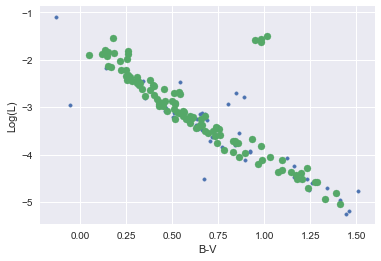

In [46]:
# simple median membership voting
meta_labels=df_label_list[gClassifiers].median(axis=1)
members  = X_Hip[meta_labels == 1.]
outliers = X_Hip[meta_labels == -1.]
ind = np.arange(0,X_Hip.shape[0],1)
print "Number of members:",members.shape[0]
print "Number of outliers:",outliers.shape[0]
labels = np.copy(meta_labels).reshape(X_Hip.shape[0])
plot_HR_Hyades()

We finally reject 49 candidates based on their proper motions.

In [47]:
BV_Hya = BV[labels == 1.]
LogL_Hya = LogL[labels == 1.]
#help("sklearn.cluster.DBSCAN")
X_HR = np.vstack((BV_Hya,LogL_Hya))
X_HR=X_HR.T
#X_HR = StandardScaler().fit_transform(X_HR)
db = DBSCAN(eps=0.2,min_samples=3).fit(X_HR)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
cluster_labels = db.labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(cluster_labels))-(1 if -1 in cluster_labels else 0)
print('Estimated number of clusters: %d' % n_clusters_)

Estimated number of clusters: 2


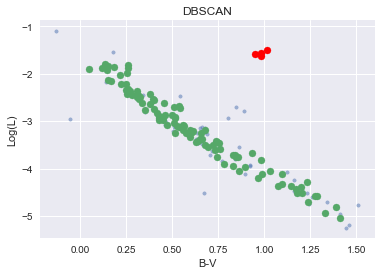

In [48]:
def plot_Hya_HR_clustering(title):
    LogL = (15.-df_area['Vmag']-5.*np.log(df_area['Plx']))/2.5
    plt.scatter(df_area['B-V'],LogL,alpha=0.5,marker=".")
    plt.scatter(BV_Hya[cluster_labels == 0],LogL_Hya[cluster_labels == 0],
            alpha=1,marker="o")
    plt.scatter(BV_Hya[cluster_labels == 1],LogL_Hya[cluster_labels == 1],
            alpha=1,marker="o",color="red")
    plt.xlabel('B-V')
    plt.ylabel('Log(L)')
    plt.title(title)
    plt.show()
    
plot_Hya_HR_clustering("DBSCAN")

Plotted in ligh blue are the stars within the location box, which are not members.

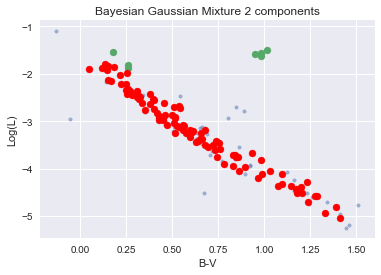

In [49]:
n_clusters_ = 2
gmmBayes = BayesianGaussianMixture(n_components=n_clusters_)
gmmBayes.fit(X_HR)
cluster_labels = gmmBayes.predict(X_HR)
plot_Hya_HR_clustering("Bayesian Gaussian Mixture 2 components")

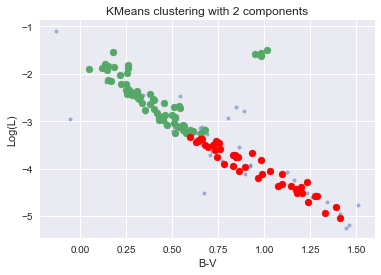

In [50]:
n_clusters_ = 2
km = KMeans(n_clusters_)
km.fit(X_HR)
cluster_labels = km.predict(X_HR)
plot_Hya_HR_clustering("KMeans clustering with 2 components")

KMeans fails on elongated groups (large distances).

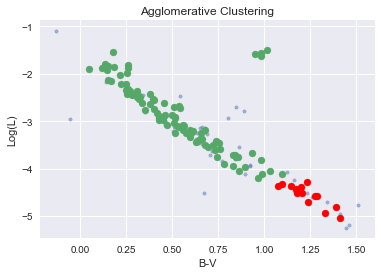

In [51]:
n_clusters_ = 2
ACmodel = AgglomerativeClustering(n_clusters=n_clusters_,
                                  affinity='euclidean',linkage='average')
ACmodel.fit(X_HR)
cluster_labels = ACmodel.labels_
plot_Hya_HR_clustering("Agglomerative Clustering")

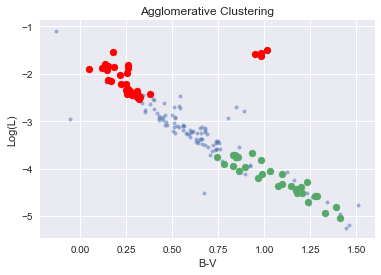

In [52]:
n_clusters_ = 3
ACmodel = AgglomerativeClustering(n_clusters=n_clusters_,
                                  affinity='manhattan',linkage='complete')
ACmodel.fit(X_HR)
cluster_labels = ACmodel.labels_
plot_Hya_HR_clustering("Agglomerative Clustering")

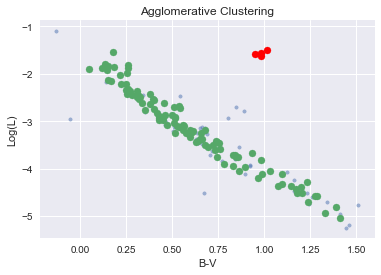

In [53]:
n_clusters_ = 2
ACmodel = AgglomerativeClustering(n_clusters=n_clusters_,
                                  affinity='cosine',linkage='complete')
ACmodel.fit(X_HR)
cluster_labels = ACmodel.labels_
plot_Hya_HR_clustering("Agglomerative Clustering")

Affinity Propagation as it does not enforce equal-size clusters.

from sklearn:
AffinityPropagation creates clusters by sending messages between pairs of samples until convergence. A dataset is then described using a small number of exemplars, which are identified as those most representative of other samples. The messages sent between pairs represent the suitability for one sample to be the exemplar of the other, which is updated in response to the values from other pairs. This updating happens iteratively until convergence, at which point the final exemplars are chosen, and hence the final clustering is given.

Affinity Propagation can be interesting as it chooses the number of clusters based on the data provided. For this pur- pose, the two important parameters are the preference, which controls how many exemplars are used, and the damping factor which damps the responsibility and availability messages to avoid numerical oscillations when updating these messages.
The main drawback of Affinity Propagation is its complexity. The algorithm has a time complexity of the order 𝑂(𝑁2𝑇), where 𝑁 is the number of samples and 𝑇 is the number of iterations until convergence. Further, the memory complexity is of the order 𝑂(𝑁2) if a dense similarity matrix is used, but reducible if a sparse similarity matrix is used. This makes Affinity Propagation most appropriate for small to medium sized datasets.

Preferences for each point - points with larger values of preferences are more likely to be chosen as exemplars. The number of exemplars, ie of clusters, is influenced by the input preferences value. If the preferences are not passed as arguments, they will be set to the median of the input similarities.array-like, shape (n_samples,) 

Ref. Brendan J. Frey and Delbert Dueck, “Clustering by Passing Messages Between Data Points”, Science Feb. 2007

Estimated number of clusters: 2
Silhouette Coefficient: 0.685


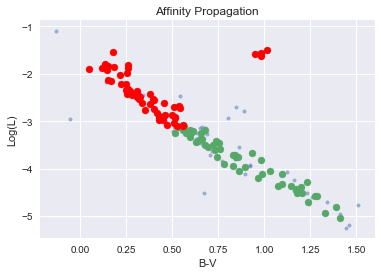

In [54]:
from sklearn.cluster import AffinityPropagation
from sklearn.metrics import silhouette_score
# Compute Affinity Propagation
af = AffinityPropagation(preference=-20).fit(X_HR)
cluster_centers_indices = af.cluster_centers_indices_
af_labels = af.labels_
n_clusters_ = len(cluster_centers_indices)
print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f"
      % silhouette_score(X_HR, af_labels, metric='sqeuclidean'))
cluster_labels = af_labels
plot_Hya_HR_clustering("Affinity Propagation")

Estimated number of clusters: 3
Silhouette Coefficient: 0.713


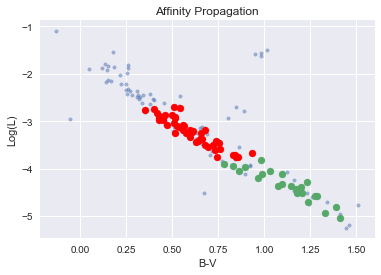

In [69]:
# Compute Affinity Propagation
af = AffinityPropagation(damping=0.9,preference=-15).fit(X_HR)
cluster_centers_indices = af.cluster_centers_indices_
af_labels = af.labels_
n_clusters_ = len(cluster_centers_indices)
print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f"
      % silhouette_score(X_HR, af_labels, metric='sqeuclidean'))
cluster_labels = af_labels
plot_Hya_HR_clustering("Affinity Propagation")

With the HR diagram limited to the candiate Hyades members, the Agglomerative Clustering method with cosine affinity and complete linkage is able to distuinguish the sub-giants from the main-sequence stars.

In [55]:
df_Hya=df_area[labels == 1.]
Plx_Hya = df_Hya['Plx']
print "Parallax statistics of the candidate members"
Plx_Hya.describe()

Parallax statistics of the candidate members


count    111.000000
mean      22.141712
std        1.241749
min       20.010000
25%       21.215000
50%       21.870000
75%       23.050000
max       25.000000
Name: Plx, dtype: float64

In [56]:
mean_Hya_dist = 1e3/Plx_Hya.mean()
print "Hyades average distance",mean_Hya_dist," pc"
err1 = 1e3/(Plx_Hya.mean()+Plx_Hya.std())
err2 = 1e3/(Plx_Hya.mean()-Plx_Hya.std())
print 'interval 1 std (pc)',err1,err2

Hyades average distance 45.1636265985  pc
interval 1 std (pc) 42.7652701304 47.8469745722


We found an average distance of 45.1 pc. Since our distance dispersion around the average value is large, false positive assigment is likely. One can restrict the search to a small area to limit contamination.

The cluster has a distance of 46.34 +/- 0.27 pc from the Perryman et al. paper.

In [57]:
# 4 red giants HIP 20205, 20455, 20889, 20885 with Vmag <4 are found 
df_Hya[(df_Hya['Vmag'] < 4.) & (df_Hya['B-V'] > 0.9)]

,HIP,Vmag,RA,DE,Plx,pmRA,pmDE,e_Plx,B-V
572,20205,3.65,64.948058,15.627700,21.17,115.29,-23.86,1.17,0.981
583,20455,3.77,65.733447,17.542584,21.29,107.75,-28.84,0.93,0.983
629,20885,3.84,67.143468,15.962217,20.66,104.76,-15.01,0.85,0.952
630,20889,3.53,67.153889,19.180521,21.04,107.23,-36.77,0.82,1.014


In [58]:
df_Hya[df_Hya['HIP'] == 20901] # potential binary

,HIP,Vmag,RA,DE,Plx,pmRA,pmDE,e_Plx,B-V
635,20901,5.02,67.208754,13.047639,20.33,105.17,-15.08,0.84,0.215


In [59]:
# Objects of interest in Perryman et al. Hip 17962, 20205, 20894, ...
df_Hya[df_Hya['HIP'] == 20894] # binary star 78 Tau

,HIP,Vmag,RA,DE,Plx,pmRA,pmDE,e_Plx,B-V
632,20894,3.4,67.165312,15.870947,21.89,108.66,-26.39,0.83,0.179


In [60]:
df_Hya[df_Hya['HIP'] == 17962] # it lies below the main-sequence branch
# it is V471 Tau (WD 0347+171), an eclipsing binary consisting of a 
# K0V star and a white dwarf

,HIP,Vmag,RA,DE,Plx,pmRA,pmDE,e_Plx,B-V
515,17962,9.46,57.603705,17.246563,21.37,130.19,-23.3,1.62,0.782


In [61]:
# The star with the bluest colour index is HIP 20648 (vB56), 
# a known blue straggler (Abt 1985, Eggen 1995).
df_Hya[df_Hya['B-V'] < 0.1]

,HIP,Vmag,RA,DE,Plx,pmRA,pmDE,e_Plx,B-V
605,20648,4.3,66.372156,17.927989,22.05,108.26,-32.47,0.77,0.049


In [62]:
df_Hya[df_Hya['HIP'] == 20614] # potential binary

,HIP,Vmag,RA,DE,Plx,pmRA,pmDE,e_Plx,B-V
599,20614,5.97,66.237749,19.042092,20.4,110.73,-32.5,0.74,0.378


#### Conclusion
- we have explored different techniques to find outliers
- we also tested different algorithms to find star categories in a HR diagram